In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
hcho_data = pd.read_csv('preprocessed_dataset/kan_pp.csv')
hcho_data.head()

,HCHO Reading,Location,Current Date,Next Date
0,0.000176,Kandy Proper,2019-01-01,2019-01-02
1,0.000092,Kandy Proper,2019-01-02,2019-01-03
2,0.000092,Kandy Proper,2019-01-03,2019-01-04
3,0.000191,Kandy Proper,2019-01-04,2019-01-05
4,0.000122,Kandy Proper,2019-01-05,2019-01-06


In [3]:
hcho_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO Reading  1826 non-null   float64
 1   Location      1826 non-null   object 
 2   Current Date  1826 non-null   object 
 3   Next Date     1826 non-null   object 
dtypes: float64(1), object(3)
memory usage: 57.2+ KB


In [4]:
hcho_data["Current Date"] = pd.to_datetime(hcho_data['Current Date'])
hcho_data["Next Date"] = pd.to_datetime(hcho_data['Next Date'])
hcho_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   HCHO Reading  1826 non-null   float64       
 1   Location      1826 non-null   object        
 2   Current Date  1826 non-null   datetime64[ns]
 3   Next Date     1826 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 57.2+ KB


In [5]:
hcho_data.set_index("Next Date", inplace=True)
hcho_data.head()

,HCHO Reading,Location,Current Date
Next Date,,,
2019-01-02,0.000176,Kandy Proper,2019-01-01
2019-01-03,0.000092,Kandy Proper,2019-01-02
2019-01-04,0.000092,Kandy Proper,2019-01-03
2019-01-05,0.000191,Kandy Proper,2019-01-04
2019-01-06,0.000122,Kandy Proper,2019-01-05


In [6]:
# Rename the column
hcho_data = hcho_data.rename(columns={"HCHO Reading": "HCHO_Levels"})

<Axes: xlabel='Next Date', ylabel='HCHO_Levels'>

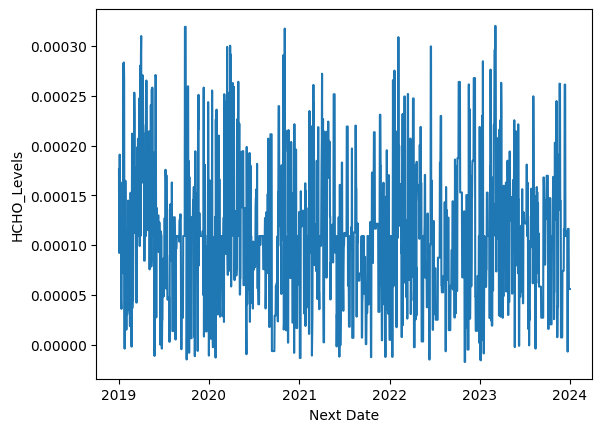

In [7]:
sns.lineplot(data=hcho_data, x = hcho_data.index, y= hcho_data.HCHO_Levels)

In [8]:
hcho_data["rollMean"] = hcho_data.HCHO_Levels.rolling(window=12).mean()
hcho_data["rollStd"] = hcho_data.HCHO_Levels.rolling(window=12).std()

<Axes: xlabel='Next Date', ylabel='HCHO_Levels'>

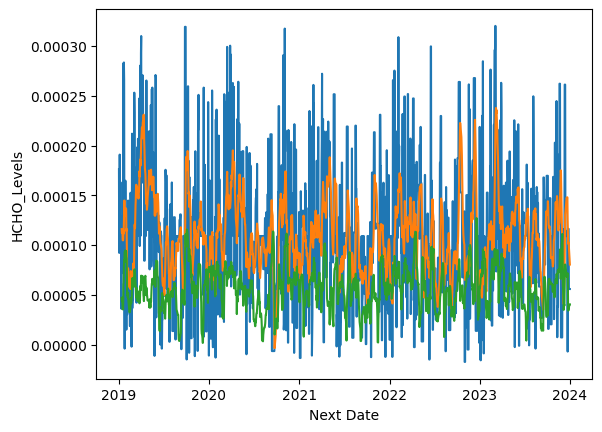

In [9]:
sns.lineplot(data=hcho_data, x = hcho_data.index, y= hcho_data.HCHO_Levels)
sns.lineplot(data=hcho_data, x = hcho_data.index, y= hcho_data.rollMean)
sns.lineplot(data=hcho_data, x = hcho_data.index, y= hcho_data.rollStd)

In [10]:
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(hcho_data["HCHO_Levels"], autolag="AIC")
adfTest

(-16.57940735318715,
 1.839917148460304e-29,
 2,
 1823,
 {'1%': -3.4339421732313236,
  '5%': -2.8631267441543695,
  '10%': -2.5676147289449824},
 -30066.015950668996)

In [11]:
stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '# Lags used', '# observvations used'])
stats

Test Statistic         -1.657941e+01
p-value                 1.839917e-29
# Lags used             2.000000e+00
# observvations used    1.823000e+03
dtype: float64

In [12]:
for key, values in adfTest[4].items():
    print("Criticality", key, ":", values)

Criticality 1% : -3.4339421732313236
Criticality 5% : -2.8631267441543695
Criticality 10% : -2.5676147289449824


In [13]:
log_df = hcho_data[["HCHO_Levels"]]
log_df['log'] = np.log(log_df["HCHO_Levels"])
log_df.head()

,HCHO_Levels,log
Next Date,,
2019-01-02,0.000176,-8.644621
2019-01-03,0.000092,-9.291508
2019-01-04,0.000092,-9.291508
2019-01-05,0.000191,-8.563927
2019-01-06,0.000122,-9.011885


<Axes: xlabel='Next Date', ylabel='HCHO_Levels'>

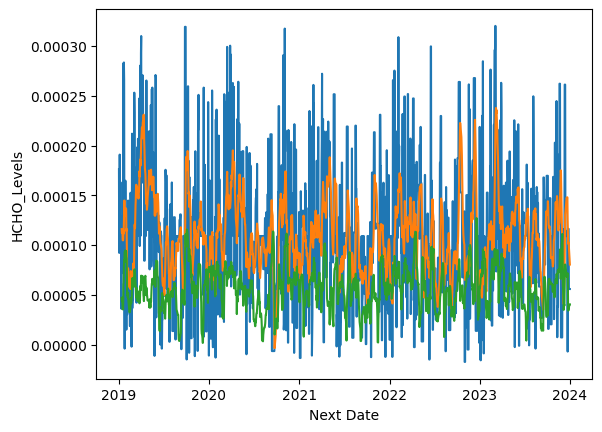

In [14]:
log_df["rollMean"] = log_df.HCHO_Levels.rolling(window=12).mean()
log_df["rollStd"] = log_df.HCHO_Levels.rolling(window=12).std()

sns.lineplot(data=log_df, x = log_df.index, y= log_df.HCHO_Levels)
sns.lineplot(data=log_df, x = log_df.index, y= log_df.rollMean)
sns.lineplot(data=log_df, x = log_df.index, y= log_df.rollStd)

In [33]:
log_df['log'] = log_df['log'].abs()
log_df2 = log_df[["HCHO_Levels", "log"]]
log_df2["log_sqrt"] = np.sqrt(log_df['log'])
log_df2["log_sqrt_shift"] = log_df2["log_sqrt"] - log_df2["log_sqrt"].shift()
log_df2.head()

,HCHO_Levels,log,log_sqrt,log_sqrt_shift
Next Date,,,,
2019-01-02,0.000176,8.644621,2.940174,NaN
2019-01-03,0.000092,9.291508,3.048197,0.108024
2019-01-04,0.000092,9.291508,3.048197,0.000000
2019-01-05,0.000191,8.563927,2.926419,-0.121779
2019-01-06,0.000122,9.011885,3.001980,0.075561


<Axes: xlabel='Next Date', ylabel='HCHO_Levels'>

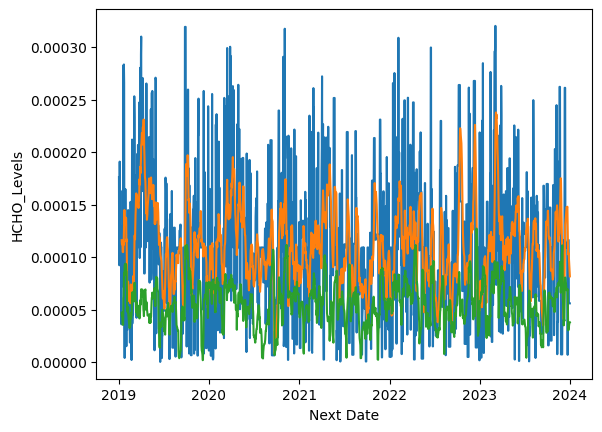

In [34]:
log_df2["rollMean"] = log_df2.HCHO_Levels.rolling(window=12).mean()
log_df2["rollStd"] = log_df2.HCHO_Levels.rolling(window=12).std()

sns.lineplot(data=log_df2, x = log_df2.index, y= log_df2.HCHO_Levels)
sns.lineplot(data=log_df2, x = log_df2.index, y= log_df2.rollMean)
sns.lineplot(data=log_df2, x = log_df2.index, y= log_df2.rollStd)

In [51]:
df = log_df2[["log_sqrt_shift"]]
df.head()

,log_sqrt_shift
Next Date,
2019-01-02,NaN
2019-01-03,0.108024
2019-01-04,0.000000
2019-01-05,-0.121779
2019-01-06,0.075561


In [52]:
df['firstDiff'] = df["log_sqrt_shift"].diff()
df['Diff12'] = df["log_sqrt_shift"].diff(12)
df.head()

,log_sqrt_shift,firstDiff,Diff12
Next Date,,,
2019-01-02,NaN,NaN,NaN
2019-01-03,0.108024,NaN,NaN
2019-01-04,0.000000,-0.108024,NaN
2019-01-05,-0.121779,-0.121779,NaN
2019-01-06,0.075561,0.197340,NaN


In [53]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

(-0.5, 1.0)

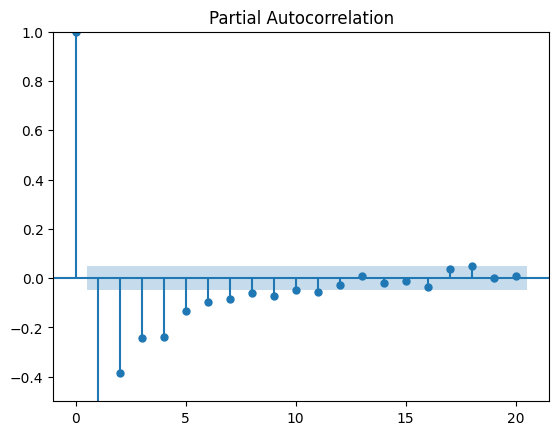

In [54]:
plot_pacf(df['firstDiff'].dropna(), lags=20)
plt.ylim(-0.5, 1)

(-0.5, 1.0)

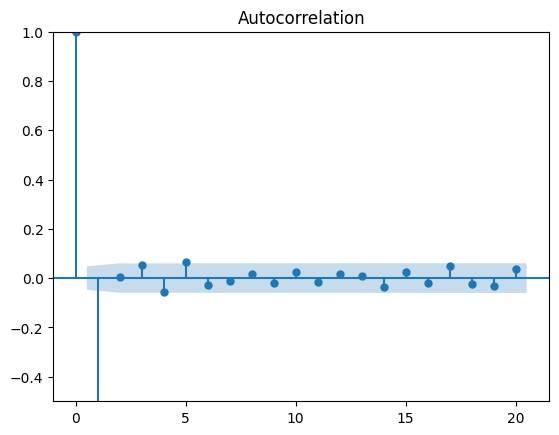

In [55]:
plot_acf(df['firstDiff'].dropna(), lags=20)
plt.ylim(-0.5, 1)

p, q and d values for the ARIMA Model --> 
p = 1 , q = 3  , d = 1 

In [56]:
train_data = df[ :round(len(df)*70/100)]
train_data.tail()

,log_sqrt_shift,firstDiff,Diff12
Next Date,,,
2022-06-28,0.134101,0.375837,0.134101
2022-06-29,-0.226922,-0.361024,-0.042359
2022-06-30,0.126001,0.352923,0.126001
2022-07-01,0.000000,-0.126001,-0.155724
2022-07-02,0.065408,0.065408,0.118152


In [57]:
test_data = df[round(len(df)*70/100): ]
test_data.tail()

,log_sqrt_shift,firstDiff,Diff12
Next Date,,,
2023-12-28,0.119348,0.119348,0.119348
2023-12-29,0.000000,-0.119348,0.000000
2023-12-30,0.000000,0.000000,0.000000
2023-12-31,0.000000,0.000000,0.000000
2024-01-01,0.000000,0.000000,0.000000


In [59]:
# Creating and fitting the ARIMA model
model = ARIMA(train_data['log_sqrt_shift'], order=(1, 1, 1))
model_fit = model.fit()

# Making predictions
prediction = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

In [60]:
df["ARIMA_Pred"] = prediction
df.tail()

,log_sqrt_shift,firstDiff,Diff12,ARIMA_Pred
Next Date,,,,
2023-12-28,0.119348,0.119348,0.119348,-0.000332
2023-12-29,0.000000,-0.119348,0.000000,-0.000332
2023-12-30,0.000000,0.000000,0.000000,-0.000332
2023-12-31,0.000000,0.000000,0.000000,-0.000332
2024-01-01,0.000000,0.000000,0.000000,-0.000332


(array([17532., 17897., 18262., 18628., 18993., 19358., 19723.]),
 [Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024')])

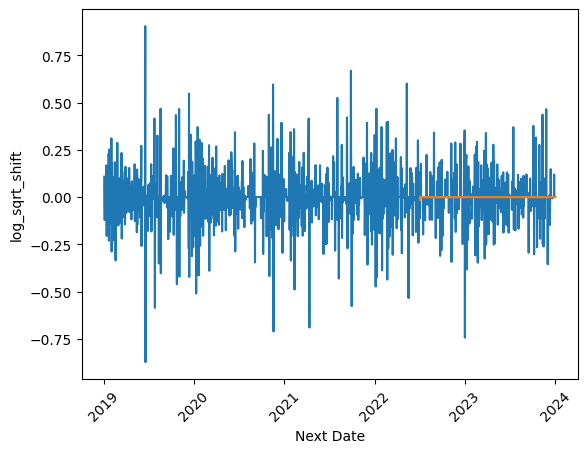

In [62]:
sns.lineplot(data = df, x = df.index, y = df.log_sqrt_shift)
sns.lineplot(data = df, x = df.index, y = df.ARIMA_Pred)
plt.xticks(rotation=45)

In [63]:
np.sqrt(mean_squared_error(test_data["HCHO_Levels"], prediction))

ValueError: Input contains NaN.

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

(-0.25, 1.0)

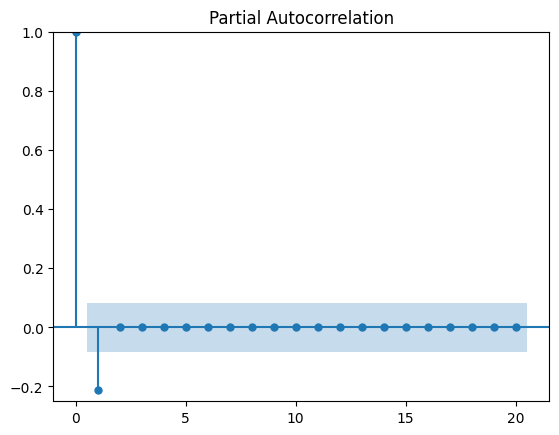

In [65]:
plot_pacf(df["ARIMA_Pred"].dropna(), lags=20)
plt.ylim(-0.25, 1)

In [66]:
model = SARIMAX(train_data['log_sqrt_shift'], order=(1, 1, 5), seasonal_order = (1, 1, 5, 12))
model_fit = model.fit()

# Making predictions
prediction = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

In [70]:
df["SARIMAX_Pred"] = prediction
df.tail()

,log_sqrt_shift,firstDiff,Diff12,ARIMA_Pred,SARIMAX_Pred
Next Date,,,,,
2023-12-28,0.119348,0.119348,0.119348,-0.000332,-0.016102
2023-12-29,0.000000,-0.119348,0.000000,-0.000332,0.017344
2023-12-30,0.000000,0.000000,0.000000,-0.000332,0.001415
2023-12-31,0.000000,0.000000,0.000000,-0.000332,-0.002420
2024-01-01,0.000000,0.000000,0.000000,-0.000332,0.001319


<Axes: xlabel='Next Date', ylabel='log_sqrt_shift'>

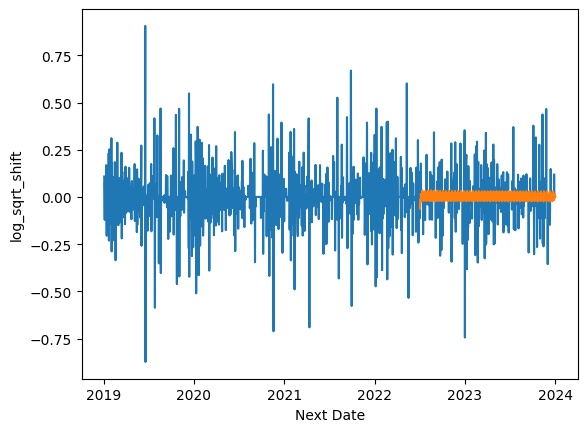

In [71]:
df.dropna()
sns.lineplot(data = df, x = df.index, y = df.log_sqrt_shift)
sns.lineplot(data = df, x = df.index, y = df.SARIMAX_Pred)